In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('stud_math.csv')

In [3]:
display(df.head())
df.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
pd.DataFrame(df.school)

,school
0,GP
1,GP
2,GP
3,GP
4,GP
...,...
390,MS
391,MS
392,MS
393,MS


In [5]:
df.school.value_counts()

GP    349
MS     46
Name: school, dtype: int64

In [6]:
df.sex

0      F
1      F
2      F
3      F
4      F
      ..
390    M
391    M
392    M
393    M
394    M
Name: sex, Length: 395, dtype: object

In [7]:
df.sex.value_counts()

F    208
M    187
Name: sex, dtype: int64

In [8]:
df.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'score'],
      dtype='object')

In [9]:
df.columns = ['school', 'sex', 'age', 'address', 'family_size', 'parents_status', 'mother_edu',
              'father_edu', 'mother_job', 'father_job', 'choose_reason', 'guardian', 'travel_time',
              'study_time', 'failures', 'school_support', 'family_support', 'paid', 'activities',
              'nursery', 'studytime-granular', 'higher', 'internet', 'romantic', 'family_rel', 'free_time',
              'go_out', 'health', 'absences', 'score']

In [10]:
df

,school,sex,age,address,family_size,parents_status,mother_edu,father_edu,mother_job,father_job,...,studytime-granular,higher,internet,romantic,family_rel,free_time,go_out,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,...,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,...,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,...,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,...,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


In [11]:
df.age.value_counts()

16    104
17     98
18     82
15     82
19     24
20      3
22      1
21      1
Name: age, dtype: int64

In [12]:
df.age.median()

17.0

<AxesSubplot:>

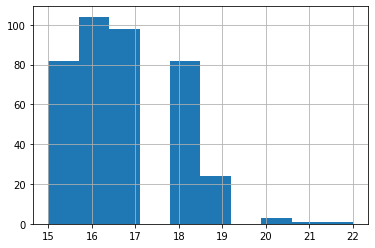

In [13]:
df.age.hist()

In [ ]:
df.address.loc[df.address == ''].count()

In [24]:
def get_info(column):
    display(df[column].value_counts())
    df.loc[:,[column]].info()

In [31]:
def empty_val(column):
    if df[column].dtype == 'object':
        result = df.address.loc[df.address == ''].count()
        df[column] = df[column].astype(str).apply(lambda x: None if x.strip() == '' else x)
        return result
    return None

In [26]:
get_info('parents_status')

T    314
A     36
Name: parents_status, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   parents_status  350 non-null    object
dtypes: object(1)
memory usage: 3.2+ KB


In [34]:
for column in df.columns:
    print(empty_val(column))

0
0
None
0
0
0
None
None
0
0
0
0
None
None
None
0
0
0
0
0
None
0
0
0
None
None
None
None
None
None


In [61]:
def test(column):
    if df[column].dtype == "float64":
        medain = df[column].median()
        perc25 = df[column].quantile(q=0.25)
        perc75 = df[column].quantile(q=0.75)
        IQR = perc75 - perc25
        print('{}: '.format(column), '25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
        return df[column].loc[df[column] > perc75 + 1.5*IQR]
        
        

In [62]:
for column in df.columns:
    display(test(column))

None

None

None

None

None

None

mother_edu:  25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


Series([], Name: mother_edu, dtype: float64)

father_edu:  25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5].


11    40.0
Name: father_edu, dtype: float64

None

None

None

None

travel_time:  25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


61     4.0
108    4.0
149    4.0
164    4.0
228    4.0
327    4.0
375    4.0
Name: travel_time, dtype: float64

study_time:  25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5].


47     4.0
66     4.0
67     4.0
69     4.0
70     4.0
71     4.0
76     4.0
77     4.0
94     4.0
95     4.0
105    4.0
106    4.0
108    4.0
121    4.0
140    4.0
204    4.0
210    4.0
256    4.0
259    4.0
271    4.0
282    4.0
293    4.0
298    4.0
303    4.0
330    4.0
334    4.0
338    4.0
Name: study_time, dtype: float64

failures:  25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].


2      3.0
18     3.0
25     2.0
40     1.0
44     1.0
      ... 
384    1.0
387    1.0
389    1.0
390    2.0
392    3.0
Name: failures, Length: 80, dtype: float64

None

None

None

None

None

studytime-granular:  25-й перцентиль: -6.0, 75-й перцентиль: -3.0, IQR: 3.0,  Границы выбросов: [-10.5, 1.5].


Series([], Name: studytime-granular, dtype: float64)

None

None

None

family_rel:  25-й перцентиль: 4.0, 75-й перцентиль: 5.0, IQR: 1.0,  Границы выбросов: [2.5, 6.5].


Series([], Name: family_rel, dtype: float64)

free_time:  25-й перцентиль: 3.0, 75-й перцентиль: 4.0, IQR: 1.0,  Границы выбросов: [1.5, 5.5].


Series([], Name: free_time, dtype: float64)

go_out:  25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0].


Series([], Name: go_out, dtype: float64)

health:  25-й перцентиль: 3.0, 75-й перцентиль: 5.0, IQR: 2.0,  Границы выбросов: [0.0, 8.0].


Series([], Name: health, dtype: float64)

absences:  25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64

score:  25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0,  Границы выбросов: [-5.0, 115.0].


Series([], Name: score, dtype: float64)

In [56]:
test('absences')

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


40      25.0
74      54.0
103     26.0
183     56.0
198     24.0
205     28.0
216     22.0
222    385.0
260     21.0
276     75.0
277     22.0
280     30.0
307     38.0
313     22.0
315     40.0
320     23.0
390    212.0
Name: absences, dtype: float64

In [55]:
df.score.value_counts()

50.0     54
55.0     46
0.0      37
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64